In [1]:
%run flow_tools.py

In [2]:
folder= box_dir + "BadIdea/Flow/20210311 - QCRG Spike Lower Dose/"

In [3]:
df = load_data(folder, colnames=["WellName", "CellLine","Dose", 'Replicate'])
df2 = clean_data(df)

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


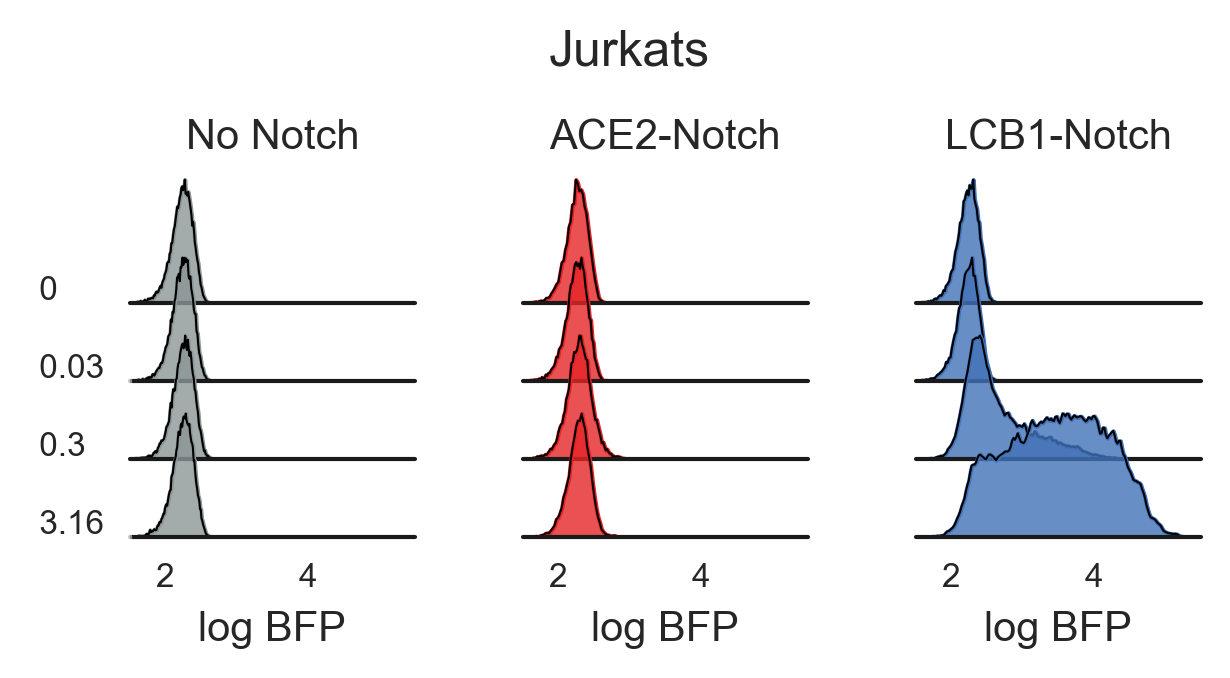

In [4]:
with sns.color_palette(["#8C9696", "#E52527", "#4272B8"]):
    doses = [str(x) for x in [0,0.03,0.3,3.16]]
    notches = ['No Notch', 'ACE2-Notch', 'LCB1-Notch']
    g = sns.FacetGrid(data=df2[(df2['logFITC-A'] > 4)],
                      row='Dose', col='CellLine', hue='CellLine', sharey=False, aspect=3, height=0.45, 
                      row_order = doses,
                      hue_order = notches,
                      col_order = notches,
                      xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    left_axes = [g.facet_axis(r, 0) for r in range(len(doses))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_dpi(300)
    g.set_xlabels("log BFP")
    plt.suptitle('Jurkats', y=1.1)
    plt.savefig(outputdir+'jurkat_spike_histogram.svg')

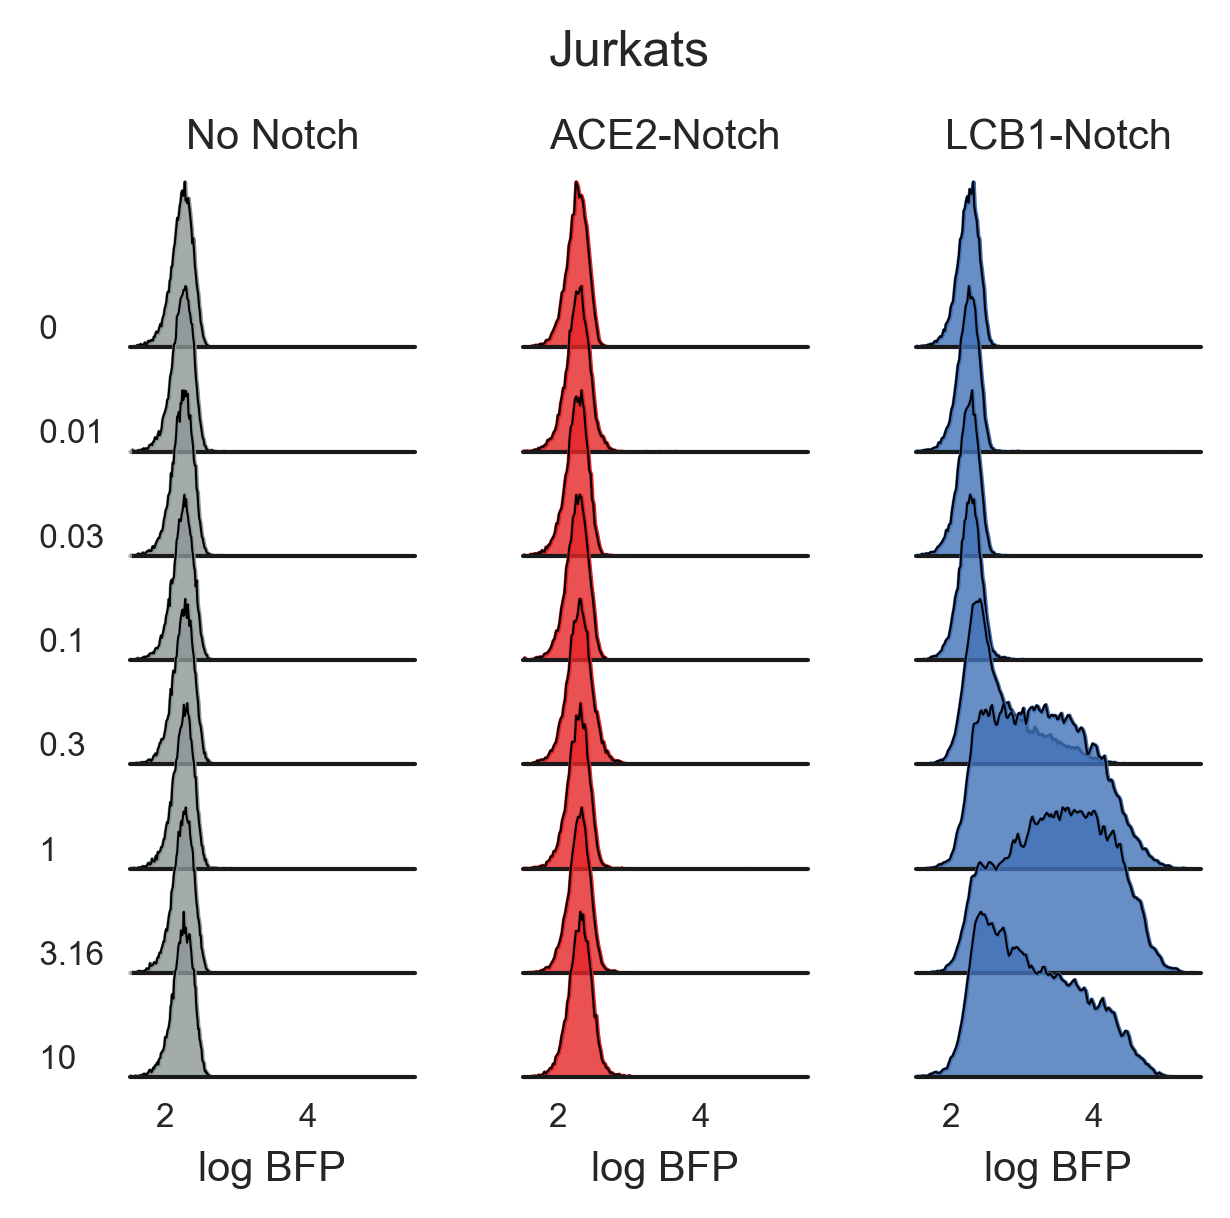

In [5]:
with sns.color_palette(["#8C9696", "#E52527", "#4272B8"]):
    doses = [str(x) for x in [0,0.01,0.03,0.1,0.3,1,3.16,10]]
    notches = ['No Notch', 'ACE2-Notch', 'LCB1-Notch']
    g = sns.FacetGrid(data=df2[(df2['logFITC-A'] > 4)],
                      row='Dose', col='CellLine', hue='CellLine', sharey=False, aspect=3, height=0.45, 
                      row_order = doses,
                      hue_order = notches,
                      col_order = notches,
                      xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    left_axes = [g.facet_axis(r, 0) for r in range(len(doses))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_dpi(300)
    g.set_xlabels("log BFP")
    plt.suptitle('Jurkats', y=1.05)
    plt.savefig(outputdir+'jurkat_spike_full_histogram.svg')

In [6]:
filters = (df2['logFITC-A'] > 4)
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['CellLine', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])

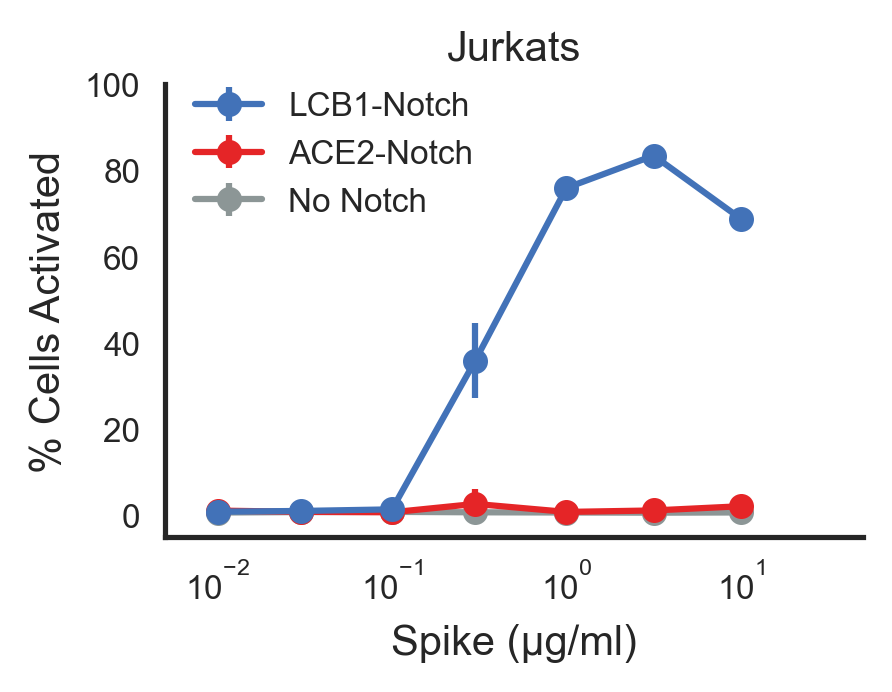

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for notch, color in zip(['No Notch', 'ACE2-Notch', 'LCB1-Notch'],['#8C9696',"#E52527", '#4272B8']):
    notch_summary = summary[(summary['CellLine']==notch) & (summary['Dose'] != 0)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('log')
ax.set_xlim([0.005, 50])
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [2, 1, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([-5,100])
sns.despine()
plt.title('Jurkats')
plt.savefig(outputdir + 'triplicate_dose.svg')

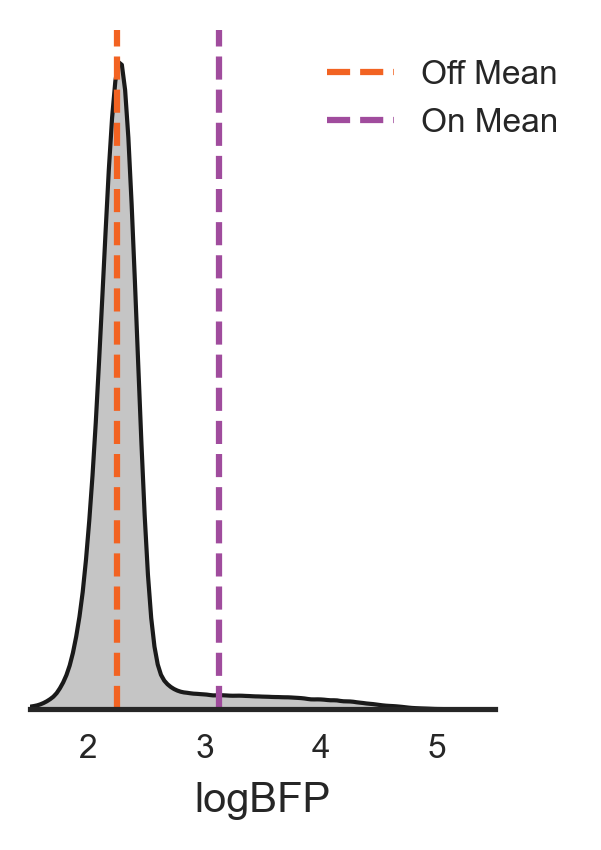

In [8]:
plt.figure(figsize=(2,3), dpi=300)
sns.kdeplot(df2[filters]['logBV 421-A'], shade=True, color='k')
sns.despine(top=True,left=True)
off_component = np.argmin(model.means_)
on_component = np.argmax(model.means_)
plt.axvline(model.means_[off_component], c="#F26322", label='Off Mean', linestyle='--')
plt.axvline(model.means_[on_component], c="#A04C9D", label= 'On Mean', linestyle='--')
plt.xlim([1.5,5.5])
plt.ylabel('')
plt.xlabel('logBFP')
plt.legend(frameon=False, bbox_to_anchor=[1.2,1])
plt.yticks([])
plt.savefig(outputdir + 'example_mixture_means.svg')

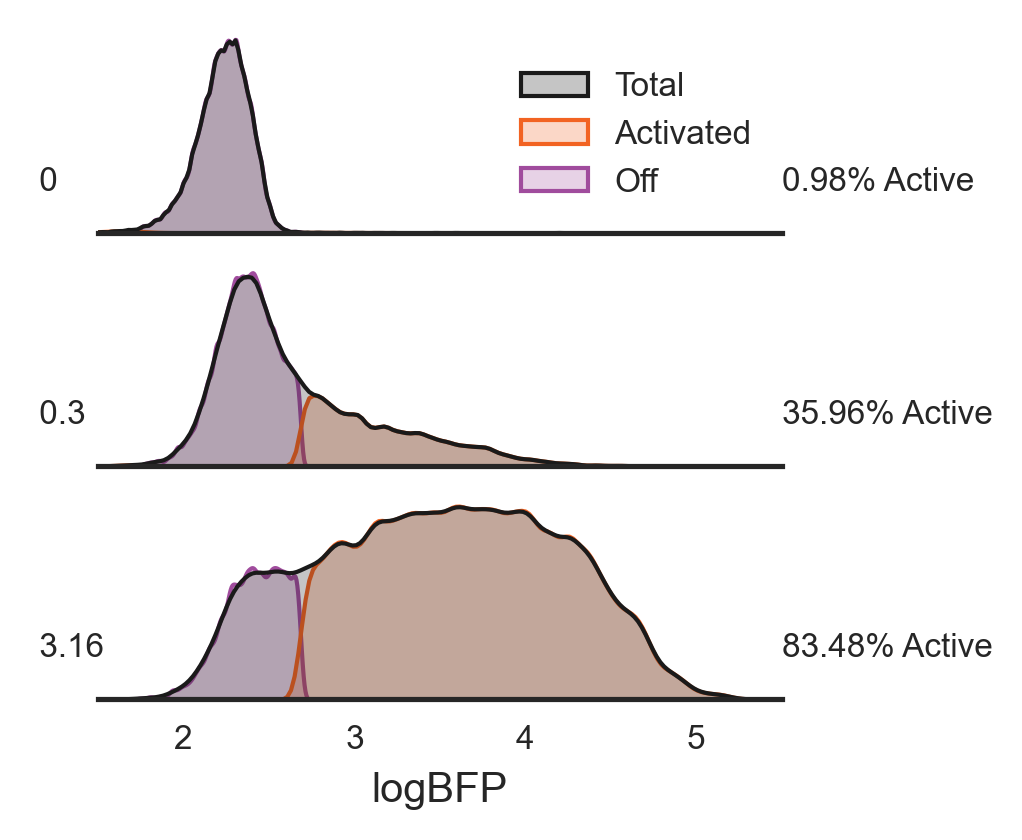

In [9]:
doses = ['0', '0.3', '3.16']
subset = df2[(df2.CellLine == 'LCB1-Notch') &
               (df2.Dose.isin(doses))][['Dose','logBV 421-A']]
subset_ = subset.copy()
subset_['Component'] = 'Total'
subset['Component'] = ['Activated' if (x == True) else 'Off' for x in model.predict(subset['logBV 421-A'][:, np.newaxis])]
subset = pd.concat([subset, subset_])
with sns.color_palette(['k','#F26322','#A04C9D']):
    g = sns.displot(data=subset, x='logBV 421-A', row='Dose', hue='Component', 
                    kind='kde', hue_order = ['Total', 'Activated', 'Off'], bw_adjust=0.5, fill=True,
                    aspect=3, height=1,
                    facet_kws={'sharey': False, 'xlim': [1.5, 5.5], 'legend_out' : False})
    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(-0.1,0.25, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    for ax, dose in zip (g.axes.flat, doses):
        percent_on = summary[(summary.CellLine=='LCB1-Notch') & (summary.Dose == float(dose))]['logBV 421-A'].mean()
        ax.text(1,0.25, f"{percent_on:.2f}% Active", ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    g.fig.subplots_adjust(hspace=0.15)
    g.fig.set_dpi(300)
    g.set_ylabels('')
    g.set_xlabels('logBFP')
    g.set_titles('')
    g.legend.set(title=None, bbox_to_anchor=[1,0.94])
    g.legend.set_frame_on(False)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    [ax.set_yticks([]) for ax in g.axes.flat]
    sns.despine(left=True)
    plt.savefig(outputdir + 'example_active_quant.svg')

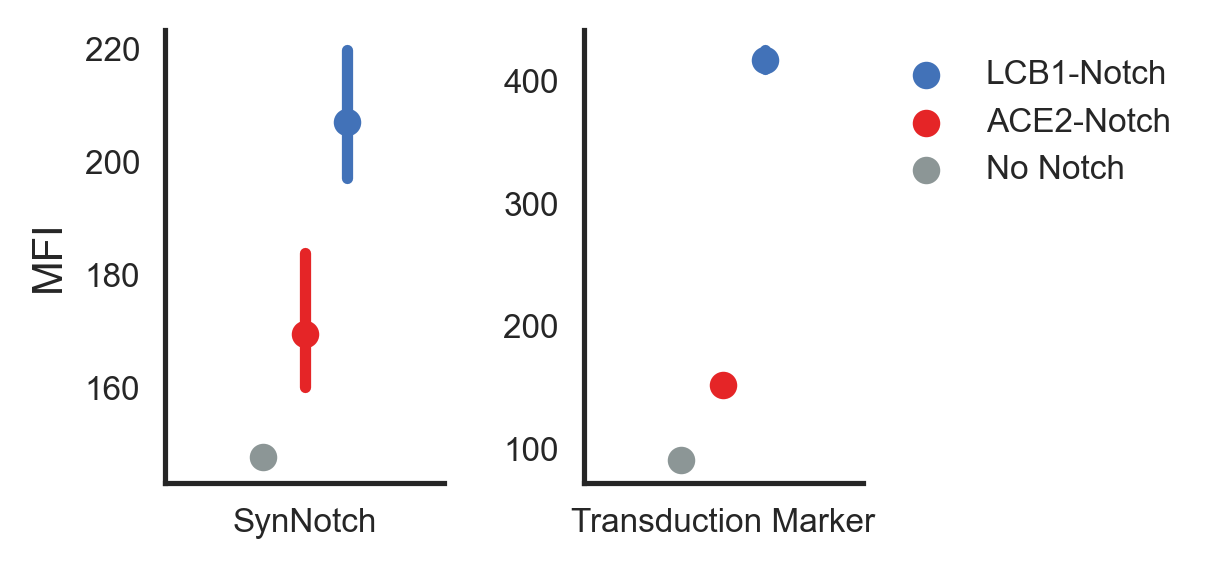

In [10]:
simplified_df = (df2[df2['logFITC-A'] > 5]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','CellLine','Dose','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['CellLine','Dose','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'SynNotch'

with sns.color_palette(['#8C9696',"#E52527", '#4272B8']):
    fig, axs = plt.subplots(1,2, figsize=(3, 2), dpi=300)
    for channel, ax in zip(['SynNotch', 'Transduction Marker'], axs):
        g = sns.pointplot(data=simplified_df[(simplified_df['CellLine']).isin(['No Notch', 'ACE2-Notch', 'LCB1-Notch']) &
                                             (simplified_df['channel'] == channel)], 
                          x='channel', y='counts', hue='CellLine',
                          hue_order=['No Notch', 'ACE2-Notch', 'LCB1-Notch'],
                          join=False, dodge=0.3, scale=0.75, ax=ax)
        g.legend().remove()
        g.set_xlabel('')
        g.set_ylabel('')
    axs[0].set_ylabel('MFI')
    handles, labels = axs[1].get_legend_handles_labels()
    order = [2, 1, 0]
    axs[1].legend([handles[idx] for idx in order],
                  [labels[idx] for idx in order],
                  frameon=False, loc='upper left', bbox_to_anchor=[1,1])
    plt.subplots_adjust(wspace=0.5)
    sns.despine()
    plt.savefig(outputdir + 'mfi_jurkats.svg')